In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from skimage import io
from itertools import chain
import pydicom

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

# EDA

Load all_xray_df and add PATH image to the data set

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
# Add PATH image into data set
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['Path'] = all_xray_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 112120


Load sample_df

In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1376,00007133_008.png,Atelectasis|Infiltration,8,7133,050Y,M,AP,2500,2048,0.171,0.171
1672,00008716_000.png,Atelectasis|Cardiomegaly,0,8716,033Y,F,PA,2500,2048,0.168,0.168
4900,00025831_000.png,No Finding,0,25831,051Y,M,PA,2992,2991,0.143,0.143


In [4]:
## check all_xray_df info
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  Path                         112120 non-null  object 
dtyp

In [5]:
# OneHotCode the Finding Labels
all_xray_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_xray_labels = [x for x in all_xray_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_xray_labels), all_xray_labels))
for label in all_xray_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)
all_xray_df['Class'] = all_xray_df['Pneumonia'].apply(lambda x: 'Pneumonia' if x==1 else "Non-pneumonia")
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Class
71381,00017605_000.png,Atelectasis|Pneumonia,0,17605,36,M,PA,2886,2991,0.143,...,0,0,0,0,0,0,0,1,0,Pneumonia
297,00000067_002.png,No Finding,2,67,66,F,PA,2992,2991,0.143,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
50210,00012699_000.png,No Finding,0,12699,44,F,PA,2506,2991,0.143,...,0,0,0,0,1,0,0,0,0,Non-pneumonia


In [6]:
# drop the Unnamed column
all_xray_df = all_xray_df.drop(columns=['Unnamed: 11'])
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Path                         112120 non-null  object 
 12  Atelectasis                  112120 non-null  int64  
 13 

In [7]:
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Atelectasis,Cardiomegaly,Consolidation,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,0.103095,0.024759,0.041625,...,0.022440,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,0.304084,0.155391,0.199732,...,0.148111,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Remove the error in the Age data

In [8]:
# AGE
all_xray_df.loc[all_xray_df['Patient Age']>120]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Class
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,0,Pneumonia
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,...,0,0,1,1,0,0,0,0,0,Non-pneumonia
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,...,0,0,0,0,0,0,0,0,1,Non-pneumonia
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,...,0,0,1,0,0,0,0,0,0,Non-pneumonia
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,...,0,0,0,1,0,0,1,0,0,Non-pneumonia


In [9]:
# remove data error in Patient Age
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 120]

### AGE

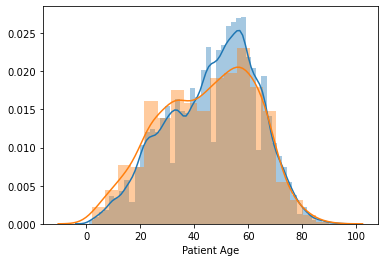

In [10]:
# age distribution for entire dataset
sns.distplot(all_xray_df['Patient Age']);
sns.distplot(all_xray_df.loc[all_xray_df.Pneumonia==1, 'Patient Age']);

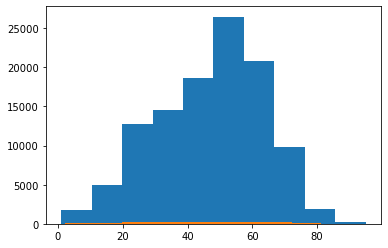

In [11]:
plt.hist(all_xray_df['Patient Age']);
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age']);

## Finding Labels

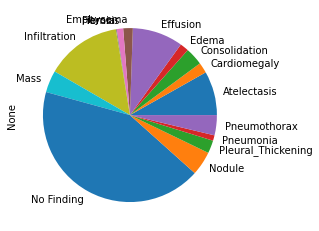

In [12]:
all_xray_df[all_xray_labels].sum().plot(kind='pie')

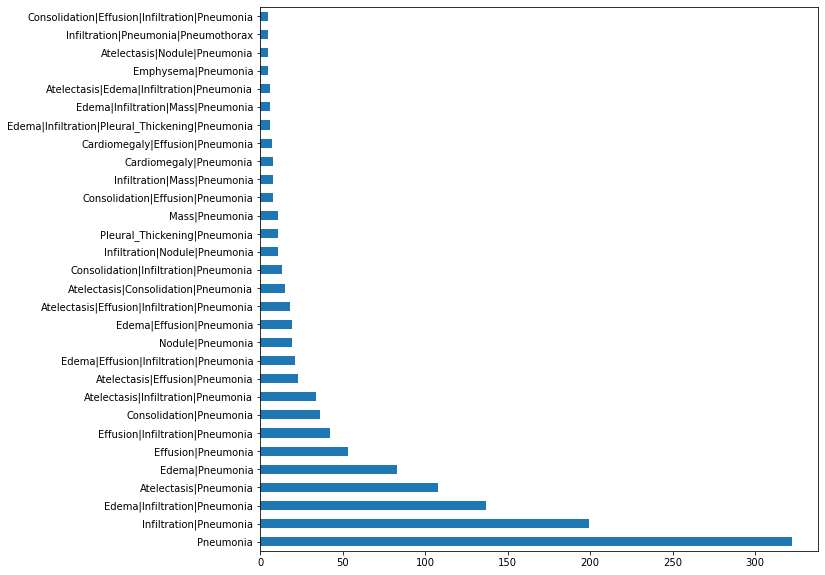

In [13]:
# check for Pneumonia
plt.figure(figsize=(10, 10))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='barh');

Pneumonia is only small part of the dataset so we must pay attention in dividing training, validation and testing data

## Gender

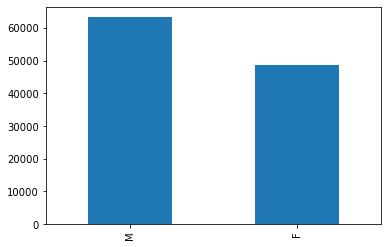

In [14]:
all_xray_df['Patient Gender'].value_counts().plot(kind='bar');

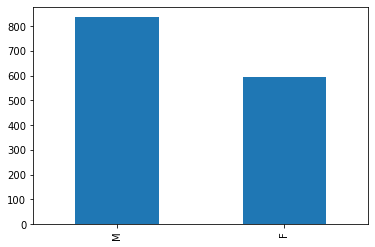

In [15]:
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar');

## View position

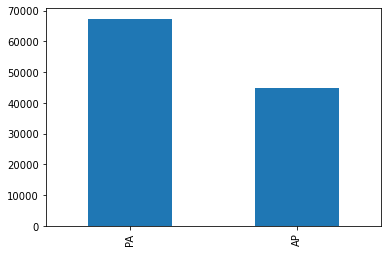

In [16]:
all_xray_df['View Position'].value_counts().plot(kind='bar');

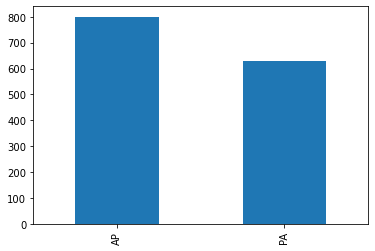

In [17]:
all_xray_df[all_xray_df.Pneumonia==1]['View Position'].value_counts().plot(kind='bar');

More patients with Pneumonia can be detected in AP position

## Pixel Level Assessment

Loading the samples

In [20]:
# Loading the sample data
images = []
for i, img_id in enumerate(sample_df['Image Index']):
    path = glob(os.path.join("/data","images*","*",img_id))[0]
    img = io.imread(path)
    images.append(img)
print("Loaded {}/{}".format(i+1, len(sample_df)))

Loaded 5606/5606


Check intensity image for the one with pneumonia and no finding

In [22]:
intensity_images = []
for i, image in enumerate(images):
    intensity_images.append(np.mean(image))
intensity_images = np.array(intensity_images)
print("Done {}/{}".format(i, len(images)))

Done 5605/5606


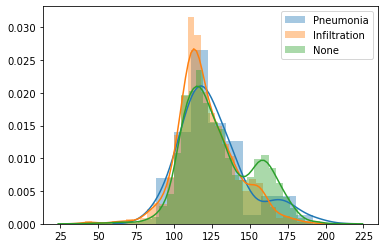

In [38]:
pneumonia_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Pneumonia")].index]
infiltration_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Infiltration")].index]
no_finding_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("No Finding")].index]
sns.distplot(pneumonia_intensity, label = "Pneumonia");
sns.distplot(infiltration_intensity, label = "Infiltration");
sns.distplot(no_finding_intensity,label = "None");
plt.legend();